# 1.0 Convolutional Neural Network Classifier

In this demo code, we will:

<ul>
<li>Design a classifier based on a convolutional neural network.</li>
<li>Use Keras as the deep learning framework.</li>
<li>Dissect the classifier by visualizing the filter activations.</li>
<li>Extract the feature space created by classifier.</li>   
<li>Get the likelihood of each input for each class label.</li> 
</ul>

In [2]:
#load Fashion MNIST dataset 

%matplotlib inline
import numpy as np
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#normalize the images
x_train = np.expand_dims(x_train/255.0, axis=-1)
x_test = np.expand_dims(x_test/255.0, axis=-1)

#convert to one-hot vector encoding
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

print(x_train.shape)
print(y_train_one_hot.shape)
print(x_test.shape)
print(y_test_one_hot.shape)

#define the labels
class_names = ['Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


In [3]:
#plot function for sample images

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

def plot_tile(samples):
    
    num_samples, x_dim, y_dim, _ = samples.shape
    #axes = np.sqrt(num_samples).astype(int)
    axes = (np.round(np.sqrt(num_samples))).astype(int)
    fig = plt.figure(figsize=(axes, axes))
    gs = gridspec.GridSpec(axes, axes)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(sample, cmap=plt.get_cmap('jet'), aspect='auto')

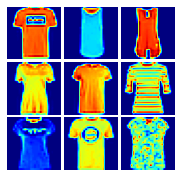

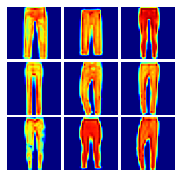

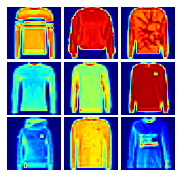

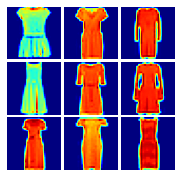

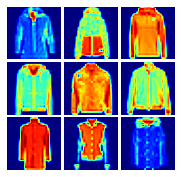

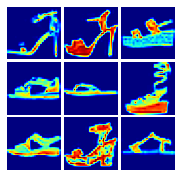

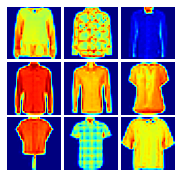

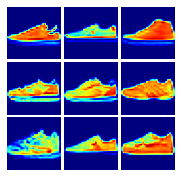

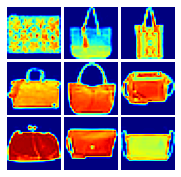

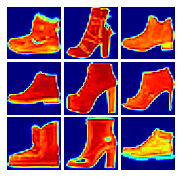

In [4]:
#visualize first 9 samples of input images based on class labels, within the training dataset

unique_labels, label_counts = np.unique(y_train, return_counts=True)

for label in unique_labels:
    x_train_perlabel = x_train[np.squeeze(y_train) == label]
    fig = plot_tile(x_train_perlabel[0:9, :, :])

In [5]:
#define a classifier with Keras 

import keras
from keras.models import Model

from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, LeakyReLU, Reshape
from keras import backend as K

from keras.optimizers import Adam
from IPython.display import clear_output
from keras.callbacks import History 

#function to view training and validation losses
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss", c = 'green')
        plt.plot(self.x, self.val_losses, label="val_loss", c = 'red')
        plt.legend()
        plt.show()

In [6]:
#define the convolutional neural network architecture

input_img = Input(shape=(x_train.shape[1], x_train.shape[1], 1)) 

_ = Conv2D(4, (3, 3), activation='linear', padding='same')(input_img)
_ = LeakyReLU(alpha=0.3)(_)
f1 = MaxPooling2D((2, 2), padding='same')(_)

_ = Conv2D(8, (4, 4), activation='linear', padding='same')(f1)
_ = LeakyReLU(alpha=0.3)(_)
f2 = MaxPooling2D((2, 2), padding='same')(_)

_ = Conv2D(16, (5, 5), activation='linear', padding='same')(f2)
_ = LeakyReLU(alpha=0.8)(_)
f3 = MaxPooling2D((2, 2), padding='same')(_)

_ = Reshape((4*4*16,))(f3)
f4 = Dense(2)(_)
out = Dense(10, activation = "softmax")(f4)

In [7]:
#set loss function, optimizer and compile

classifier = Model(input_img, out)
opt = keras.optimizers.Adam(lr=1e-3)
classifier.compile(optimizer=opt, 
                   #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, name="categorical_crossentropy"), 
                   loss="categorical_crossentropy", 
                   metrics=['accuracy'])

#get summary of architecture parameters and plot arch. diagram
classifier.summary()
from keras.utils import plot_model
plot_model(classifier, to_file='classifier.png')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 4)         40        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 4)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         520       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
________

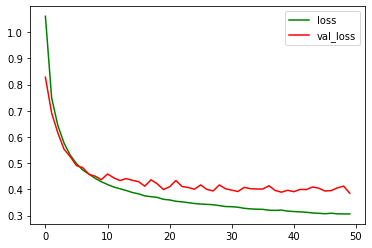

In [82]:
#train the neural network

plot_losses = PlotLosses()
classifier.fit(x_train, y_train_one_hot,        
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                callbacks=[plot_losses])

In [9]:
#get the accuracy of the trained model on the test dataset (unseen)

test_loss, test_acc = classifier.evaluate(x_test,  y_test_one_hot, verbose=2)
print('Test accuracy:', test_acc)

#get the predictions for the test dataset
predictions = classifier.predict(x_test)

Test accuracy: 0.8688


In [8]:
#save and load the trained model

#classifier.save('classifier.h5')

#from keras.models import load_model
#classifier = load_model('classifier.h5')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
#function to pretty plot confusion matrix (modified from SKLEARN)

import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[806   0  13  29   4   2 126   0  20   0]
 [  0 957   0  24  13   0   6   0   0   0]
 [ 11   1 820   3  62   0  95   0   8   0]
 [ 21   3   5 852  39   0  78   0   2   0]
 [  1   3 110  29 785   0  70   0   2   0]
 [  5   0   0   0   0 959   0  32   1   3]
 [128   1 102  30  61   0 668   0  10   0]
 [  0   0   0   0   0  32   0 945   0  23]
 [  7   1  16   0   0   1   8   4 956   7]
 [  0   0   0   0   0   6   0  49   5 940]]

Classification Report
              precision    recall  f1-score   support

         Top       0.82      0.81      0.81      1000
     Trouser       0.99      0.96      0.97      1000
    Pullover       0.77      0.82      0.79      1000
       Dress       0.88      0.85      0.87      1000
        Coat       0.81      0.79      0.80      1000
      Sandal       0.96      0.96      0.96      1000
       Shirt       0.64      0.67      0.65      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       

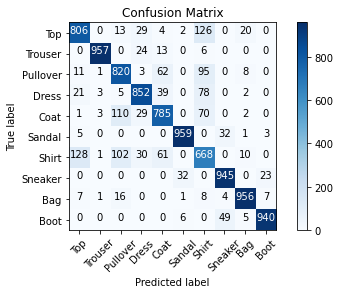

In [11]:
#print the confusion matrix and classification report

from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(y_test, predictions.argmax(axis=1))
plot_confusion_matrix(cm=matrix, classes=class_names, title='Confusion Matrix')

print('\nClassification Report')
print(classification_report(y_test, predictions.argmax(axis=1), target_names=class_names))

In [12]:
#functions to plot training data and the likelihood (from KERAS)

def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
    
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    
    plt.xticks(range(10))
    plt.yticks([])
    
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

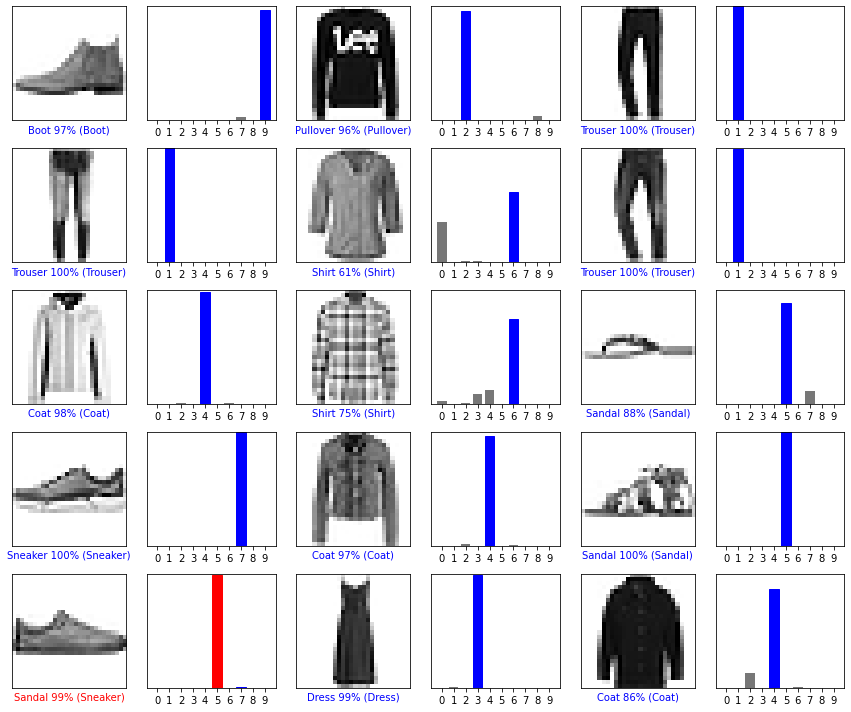

In [13]:
#plot some test images with predicted vs true labels
#correct predictions (colored blue) and incorrect predictions (colored red)

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

In [14]:
#function to tile the third dimension

def collapse_channel(w):
    
    x_dim, y_dim, channel_dim = w.shape
    axes = (np.round(np.sqrt(channel_dim))).astype(int)
    w_merged = np.zeros([x_dim*axes, y_dim*axes])
    
    k = 0
    for i in range(axes):
        for j in range(axes):

            start_xidx = i*x_dim
            end_xidx = start_xidx + x_dim
            start_yidx = j*y_dim
            end_yidx = start_yidx + y_dim   

            w_merged[start_xidx:end_xidx, start_yidx:end_yidx] = w[:, :, k]
            k = k+1
            if k == channel_dim:
                break
    return w_merged

#function to get the trained kernel weights and visualize
def get_weights(model):
    for layer in model.layers:
        if 'conv2d' in layer.name:
            print(layer.name)
            w, b = layer.get_weights()
            print("Weights of layer {} {}".format(layer.name, w.shape))
            
            w_max, w_min = np.max(w), np.min(w)
            w = (w - w_min) / (w_max - w_min)
            
            plt.figure()
            for i in range(w.shape[-1]):
                axes = (np.round(np.sqrt(w.shape[-1]))).astype(int)
                ax = plt.subplot(axes, axes, i+1)
                
                #tile within each subplot
                w_i = collapse_channel(w[:, :, :, i])
                plt.imshow(w_i, cmap='jet')
                plt.xticks([])
                plt.yticks([])
                plt.axis('off')
                ax.set_aspect('equal')

conv2d_40
Weights of layer conv2d_40 (3, 3, 1, 4)
conv2d_41
Weights of layer conv2d_41 (4, 4, 4, 8)
conv2d_42
Weights of layer conv2d_42 (5, 5, 8, 16)


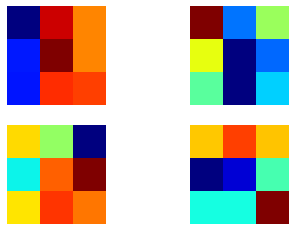

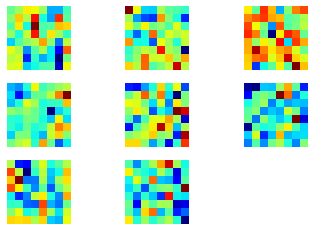

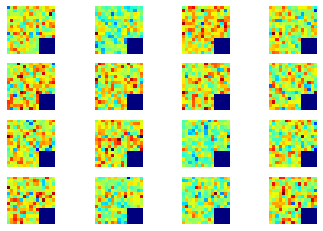

In [15]:
#get the weights for the convolutional layers

get_weights(classifier)

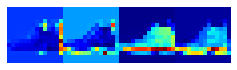

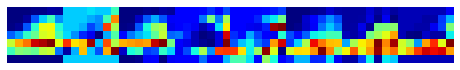

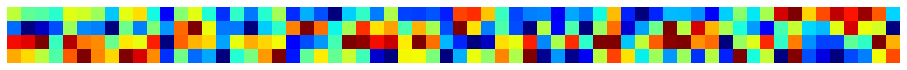

In [18]:
#visualize the activations for the convolutional layers (conv>nonlinear>pool)

test_case = 0

activations = [f1, f2, f3]
for activation in activations:
    act_classifier = Model(input_img, activation)
    act_out = act_classifier.predict(x_test[test_case:test_case+1])
    _, x_dim, y_dim, num_features = act_out.shape
    act_grid = np.zeros([x_dim, x_dim*num_features])
    
    for f_idx in range(num_features):
        feature = act_out[0, :, :, f_idx]
        feature = (feature - np.min(feature)) / (np.max(feature) - np.min(feature))
        act_grid[:, (f_idx*y_dim): (f_idx*y_dim)+y_dim] = feature
    
    plt.figure(figsize=[num_features, num_features*4])
    plt.imshow(act_grid, cmap='jet')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

In [93]:
#get the activations for the last layers (conv>nonlinear>pool)

act_classifier = Model(classifier.layers[0].input, classifier.layers[11].output)
act_out = act_classifier.predict(x_test)

Text(0.5, 1.0, 'Feature space')

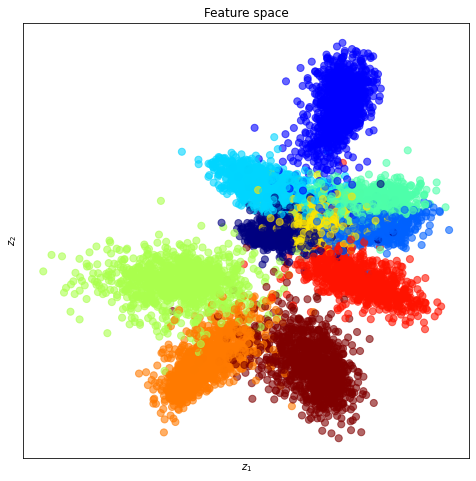

In [101]:
#plot the latent variables and color code with cum oil, gas or water
import matplotlib.cm as cm
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1,1, figsize = (8, 8))

my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_test))

ax.scatter(act_out[:, 0], act_out[:, 1], s=50, c=cs, alpha=0.6)
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Feature space')